# Read _.fits_  data

---

The main purpose of reading the _.fits_ dataset is to turn them into a pandas DataFrame. For this, it was decided to use the _Astropy_ library because it has _astropy.io.fits_, a package that allows access to FITS files. 


In [1]:
DATA_DIR = 'drive/MyDrive/01 - Iniciação Científica/02 - Datasets/dataset_exoplanets_confirmed'
FILE_SAMPLE_DIR = '/content/drive/MyDrive/01 - Iniciação Científica/02 - Datasets/dataset_exoplanets_confirmed/EN2_STAR_CHR_0101086161_20070516T060226_20071005T074409.fits'

> DATA_DIR and FILE_SAMPLE_DIR are global variables that contains the path of _.fits_ dataset and a path of a sample file in the dataset, respectively.

In [18]:
from astropy.io import fits

image_file = fits.open(FILE_SAMPLE_DIR)

print(type(image_file), "\n")
print(len(image_file))

<class 'astropy.io.fits.hdu.hdulist.HDUList'> 

4


The variable image_file has all the the information storage into a _.fits_ file. 

We need to know what we are dealing with, so in order to know our data better, the `type` command tells us that our file belongs to the HDUList class.

> A little breath for FITS: The Flexible Image Transport System (FITS) is a portable file that it is used for store, transmit and process data formatted as multi-dimensional arrays or tables. FITS is widely used in the astronomy community to store images and tables. We use the software _[QFits View](https://www.mpe.mpg.de/~ott/QFitsView/)_ to open this files in our machine and, as soon as it opens, it is ask to choose an extension. 


So, FITS files can have several extensions, in our case, by the `len` command, it only has 4.
We are only interessed in the most informative extension with the minimal computacional cost, since we are not interessed in dealing with big-data issues, the third table is the most attractive one. 


In [19]:
scidata = image_file[3].data

print(type(scidata), "\n")
print(scidata)

<class 'astropy.io.fits.fitsrec.FITS_rec'> 

[(54236.75758185, 112626.77,   0) (54236.76350826, 112605.61,   0)
 (54236.76943468, 112771.5 ,   8) ... (54378.80910033, 112496.13, 256)
 (54378.81502574, 112344.83,   0) (54378.82095114, 112318.5 ,  80)]


_Scidata_ contains the information of the third table. We can see that is belongs to the FITS_rec class and, to manipulate this type, it is decided to transform it into an array, using NumPy library



> At this point, we come to a problem that is worth commenting on. The original file, when transformed into an array, according to the code: `x = np.array(scidata)` presents the following error when being plotted, using the *Plotly* library: <br /><br /> **ValueError: Big-endian buffer not supported on little-endian compiler** <br /><br /> This error occurs when the data being worked on was created on a machine with a different byte order than the one on which we are running *Python*.
To deal with this problem, we must convert the NumPy array to the byte order of the native system before transforming it into a DataFrame or Series. <br /> <br />Therefore, we use the methods *byteswap()* e *newbyteorder*(). <br /><br />Reference: [Pandas Documentation - Byte-ordering issues](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#byte-ordering-issues)


# Transforming data as DataFrame

---

With normalized data, stored in _x_, we transform them into DataFrame and then separate the part that interests us, that means, only the columns DATABARRT and WHITEFLUXSYS.

In [24]:
import numpy as np

x = np.array(scidata).byteswap().newbyteorder()

In [25]:
import pandas as pd

data = pd.DataFrame(x)
data.head()

,DATEBARTT,WHITEFLUXSYS,STATUSSYS
0,54236.757582,112626.773438,0
1,54236.763508,112605.609375,0
2,54236.769435,112771.500000,8
3,54236.775361,113113.601562,0
4,54236.781288,112621.789062,256


In [26]:
data = data.drop('STATUSSYS', axis=1)
data.head()

,DATEBARTT,WHITEFLUXSYS
0,54236.757582,112626.773438
1,54236.763508,112605.609375
2,54236.769435,112771.500000
3,54236.775361,113113.601562
4,54236.781288,112621.789062


# Plotting the Light Curve

---

The time series is plotted using _Plotly_ as a line graph.

In [ ]:
import plotly.express as px

fig = px.line(data, x='DATEBARTT', y='WHITEFLUXSYS', title='Light Curve')
fig.show()

The Light Curve will be like this (for GitHub users)




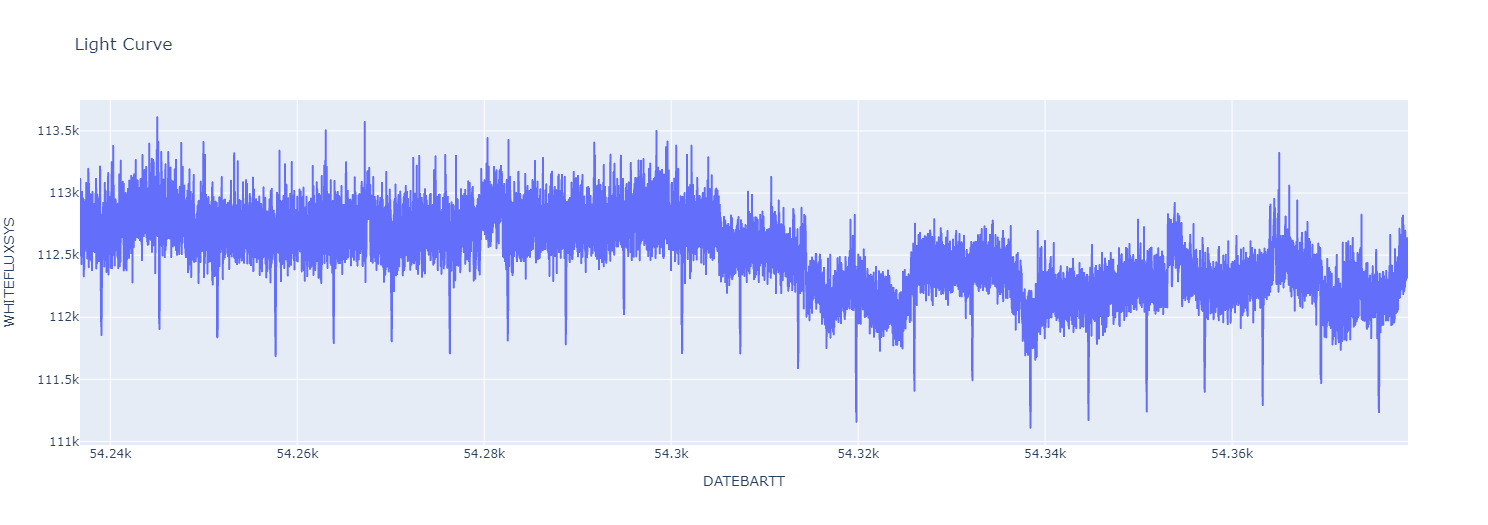

# Saving data as .csv or .txt

---

Finally, we saved the data obtained in .fits as .csv and .txt, in order to facilitate future operations.

In [30]:
# Saving as .csv
data.to_csv('data_exo.csv', index=False)

In [31]:
# Saving as .txt
import csv

csv_file = 'data_exo.csv'
txt_file = 'data_exo.txt'

with open(txt_file, "w") as output_file:
  with open(csv_file, "r") as input_file:
    [ output_file.write(" ".join(row)+'\n') for row in csv.reader(input_file) ]
  output_file.close()

# Algorithm that transform _.fits_ files into _.csv_

---

Here, the funcion presetend above convert a _.fits_ file into a _.csv_ and then, in the next coding block, we applied this funcion to all raw files presents on a DATA_DIR, which can take a while. Thereby, we just zipped and downloaded the new folder that contais all data converted to _.csv_

In [32]:
DATA_DIR = 'drive/MyDrive/01 - Iniciação Científica/02 - Datasets/dataset_exoplanets_confirmed'

In [36]:
from astropy.io import fits
import numpy as np
import pandas as pd
import plotly.express as px
import os
import shutil

def fits_converter_to_csv(path):
  """
  This is the funcion used to convert one
  .fits file into a .csv

  :param str path: Path to .fits data-set folder
  """
  image_file = fits.open(path)
  scidata = image_file[3].data
  x = np.array(scidata).byteswap().newbyteorder()
  data = pd.DataFrame(x)
  data = data.drop('STATUSSYS', axis=1)

  # Creating folder with .csv files
  CSV_DIR = 'csv_files'
  if not os.path.isdir(CSV_DIR):
    os.mkdir(CSV_DIR)

  # Renaming .csv file
  name = path[path.rfind('/')+1:path.rfind('.')] + '.csv'
  data.to_csv(name, index=False)

  # Move to .csv folder
  shutil.move(name, CSV_DIR)

**Applying *fits_converter_to_csv()* to all .fits files**

In [34]:
import os
import time

i = 0
my_dir = DATA_DIR
t_o = time.time()

for root_dir_path, sub_dirs, files in os.walk(my_dir):
  for i in range(0, len(files)):
    fits_converter_to_csv( my_dir + os.path.abspath(files[i])[os.path.abspath(files[i]).rfind('/'):] )

t_f = time.time()

print("It takes:", round(t_f-t_o, 2), "seconds to apply")

It takes: 35.11 seconds to apply


**Zipping *csv_files* folder**

In [ ]:
!zip -r /content/csv_files.zip /content/csv_files

**Downloading zipped folder**

In [ ]:
from google.colab import files
files.download("csv_files.zip")